# Part 1: Exploratory Data Analysis & Data Cleaning



## Imports and settings

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calplot
import validators
from typing import Union, Any
from datetime import datetime
import fasttext

In [3]:
sns.set_theme()

## Load the data

We import the data and drop the duplicated index column "Unnamed: 0". 

**Due to the size of the dataset, this might take some time.**

In [4]:
path = os.path.join(os.getcwd(), '../data/csv/freiesth_scrape_2.csv')
df = pd.read_csv(path, low_memory=False)
df.drop(labels="Unnamed: 0", axis=1, inplace=True)

## Initial Exploration

Now, we can start exploring the data by...

1. Inspecting column types.

2. Inspecting column values.

3. Searching the dataframe for missing datapoints.

4. Check for duplicate rows.

5. Verify dates.

6. Verify webpages.

7. Checking the distribution of messages across chats. 

### 1. Inspect column types

First, we inspect the column types to see if they match the data contained in them. To do so, we'll

1. Inspect the datatypes per columns.

2. Check the datatypes in object type columns. 


**Inspect the datatypes per columns**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1959797 entries, 0 to 1959796
Data columns (total 32 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   chat_handle              object 
 1   chat_name                object 
 2   chat_type                object 
 3   collection_time          object 
 4   fwd_from_chat_handle     object 
 5   fwd_from_chat_id         float64
 6   fwd_from_user_name       object 
 7   is_fwd                   bool   
 8   is_group_elem            bool   
 9   is_reply                 bool   
 10  message_date             object 
 11  message_fwd_count        float64
 12  message_group_id         float64
 13  message_media_type       object 
 14  message_reactions        object 
 15  message_reactions_count  float64
 16  message_text             object 
 17  message_view_count       float64
 18  post_author              float64
 19  reply_to_message_id      float64
 20  reply_to_top_message_id  float64
 21  sender_d

There are some columns that don't match the type of the data contained in them:
- `post_author`: Is `float64`, should be `object`.
- `sender_display_name`: Is `float64`, should be `object`.
- `collection_time`: Is `object`, should be `datetime`.
- `message_date`: Is `object`, should be `datetime`.
- `reply_to_message_id`: Is `float`, should be `int`.
- `reply_to_top_message_id`: Is `float`, should be `int`.
- `fwd_from_chat_id`: Is `float`, should be `int`.

**Validate object_type columns**

As the object dtype is a general-purpose dtype for columns with mixed or unknown data types, we need to make sure that they acutally contain the datatype we're looking for.

In our dataset, they should actually contain strings. Let's check, if that's actually the case.



In [6]:
# get the names of all columns of type "object"
object_colums = df.dtypes[df.dtypes == "object"].index.to_list()

# create a dataframe containing the type of each cell
df_object_types =  df[object_colums].map(type)

# print unique datatype for each column
for column in df_object_types.columns:
    print(f"Types in column \"{column}\"".upper())
    print(df_object_types[column].value_counts())
    print("")

TYPES IN COLUMN "CHAT_HANDLE"
chat_handle
<class 'str'>      1910537
<class 'float'>      49260
Name: count, dtype: int64

TYPES IN COLUMN "CHAT_NAME"
chat_name
<class 'str'>    1959797
Name: count, dtype: int64

TYPES IN COLUMN "CHAT_TYPE"
chat_type
<class 'str'>    1959797
Name: count, dtype: int64

TYPES IN COLUMN "COLLECTION_TIME"
collection_time
<class 'str'>    1959797
Name: count, dtype: int64

TYPES IN COLUMN "FWD_FROM_CHAT_HANDLE"
fwd_from_chat_handle
<class 'float'>    1509382
<class 'str'>       450415
Name: count, dtype: int64

TYPES IN COLUMN "FWD_FROM_USER_NAME"
fwd_from_user_name
<class 'float'>    1953584
<class 'str'>         6213
Name: count, dtype: int64

TYPES IN COLUMN "MESSAGE_DATE"
message_date
<class 'str'>    1959797
Name: count, dtype: int64

TYPES IN COLUMN "MESSAGE_MEDIA_TYPE"
message_media_type
<class 'str'>      1768435
<class 'float'>     191362
Name: count, dtype: int64

TYPES IN COLUMN "MESSAGE_REACTIONS"
message_reactions
<class 'str'>      1182236
<cl

As we can see, some of the columns contain elements of the type `float` -- presumably, those are nan-values, which are saved as floats in pandas.

We will replace them with empty strings down the line. 

### 2. Inspect column values

To get a feeling for the data and to weed out obvious inconsistencies, we can inspect the unqiue values for each column. 

1. First, we'll take a look at the number of unique values per column. This way we can get a feeling for which columns we can reasonably inspect manually.

2. Afterwards, we'll display the  values for each column with less or equal to 20 unique values and inspect them.

In [7]:
unique_values_per_column = df.nunique()
pd.DataFrame(unique_values_per_column, columns=["Unique values"])

,Unique values
chat_handle,4899
chat_name,4969
chat_type,2
collection_time,207393
fwd_from_chat_handle,8168
fwd_from_chat_id,9664
fwd_from_user_name,944
is_fwd,2
is_group_elem,2
is_reply,2


In [8]:
under_20 = unique_values_per_column[unique_values_per_column<=20]

for column in under_20.index:
    print(f"{df[column].value_counts()}\n")

chat_type
broadcast    1893133
megagroup      66664
Name: count, dtype: int64

is_fwd
False    1432670
True      527127
Name: count, dtype: int64

is_group_elem
False    1645573
True      314224
Name: count, dtype: int64

is_reply
False    1886155
True       73642
Name: count, dtype: int64

message_media_type
MessageMediaPhoto               830857
MessageMediaDocumentVideo       569327
MessageMediaWebPage             287285
MessageMediaDocumentAudio        43383
MessageMediaDocumentPhoto        18026
MessageMediaDocumentDocument     16989
MessageMediaPoll                  2315
MessageMediaStory                   86
MessageMediaContact                 44
MessageMediaDocumentOther           40
MessageMediaDocument                26
MessageMediaGeo                     18
MessageMediaGiveaway                18
MessageMediaInvoice                  7
MessageMediaDice                     6
MessageMediaGiveawayResults          4
MessageMediaUnsupported              4
Name: count, dtype: int64


**Findings**:

- As we can see, many columns have a high degree of unique values. This high cardinality is expected due to the inherently variable nature of Telegram messages.


- For some columns with high cardinality, the variability might be influenced by how the data is stored or measured rather than by the content itself. In these cases, we may need to transform or aggregate these columns to make them more suitable for analysis. 
   - For example, datetime columns could be aggregated into broader time periods such as hours, days, or weeks.


- For columns with few unique values, no faulty or obviously inconsistent values have been found.


### 3. Check for missing data

To understand the extent of missing data, we will examine the percentage of missing values for each column in the dataset. This helps us identify which columns have significant amounts of missing data and might require imputation or other handling strategies.


In [9]:
# print missing values per column
pd.DataFrame(df.isnull().sum().apply(lambda x: x/df.shape[0]).sort_values(ascending=False), columns = ["Missing"])

,Missing
post_author,1.000000
sender_display_name,1.000000
fwd_from_user_name,0.996830
sender_last_name,0.993001
reply_to_top_message_id,0.987378
sender_first_name,0.979443
reply_to_message_id,0.962424
webpage_author,0.949452
webpage_description,0.866623
webpage_title,0.859820


Most of these results are to be expected due to idiosyncrasies of the data collection process, Telegram's API, and the messenger's policy.

For columns with more than 10% values missing, I will provide a brief overview of the reasons why this is the case.

- `sender_display_name`: This value is usually not set because many users do not have a display name.


- `post_author`: This value is only set in certain cases, for example, if an admin of the group sends a message.

- `fwd_from_user_name`: This value is only set if a message was forwarded from a user, which seems to be rare for this dataset.

- `sender_last_name`: This value is only set if a user provided a surname, which seems to be rare for this dataset.

- `reply_to_top_message_id`: This value is only set if a message is a reply in a thread, which seems to be rare for this dataset.

- `sender_first_name`: This value is only set if a user provided a first name, which seems to be rare for this dataset.

- `reply_to_message_id`: This value is only set if a message is a reply to another message, which seems to be rare for this dataset.

- `webpage_author/description/title`: These values are only set for messages that link to a webpage, which provides a preview to Telegram. As both not all messages contain links and not all links provide previews, missing values are to be expected.

- `message_group_id`: This value is only set for messages that are part of a group (for example, photos in an album). As this is not the case for all messages, missing values are to be expected.

- `fwd_from_chat_handle`: This value is only set for messages that were forwarded from another chat. As this is not the case for all messages, missing values are to be expected.

- `fwd_from_chat_id`: Same as above.

- `message_reactions_count`: This value is only set for messages from chats that allow reactions. As this is not the case for all chat types, missing values are to be expected.

- `message_reactions`: This value is only set for messages from chats that allow reactions. As this is not the case for all chat types, missing values are to be expected.

- `message_text`: Some message types, for example, photos in an album or media files, don't contain texts. Missing values are to be expected.

- `message_fwd_count`: This value is only set for messages from chats that provide information on the forwarding counts through the API. As this is not the case for all chat types, missing values are to be expected.

**Conclusion**

- As we can see, most of the missing values actually point towards certain attributes of a message and should be considered in their analysis.

- As they don't contain any relevant information and don't point to relevant information regarding a message, these columns with missing data can be dropped.


### 4. Check for duplicates

Next, we'll check for duplicates.

In [10]:
duplicates  = df[df.duplicated()]
print(f"Duplicates found: {len(duplicates)}")

Duplicates found: 2028


As these duplicates might be referenced in other rows, it might be beneficial to keep them in order to maintain the integrity of these connections.

Let's check if they are referenced in another row. Messages could be both referenced in `reply_to_message_id` or `reply_to_top_message_id`.

In [11]:
duplicate_msg_ids = duplicates["telegram_message_id"]
print(f"Duplicates referenced in `reply_to_messages`: {df["reply_to_message_id"].isin(duplicate_msg_ids).value_counts().iloc[1]}")
print(f"Duplicates referenced in `reply_to_top_message_id`: {df["reply_to_top_message_id"].isin(duplicate_msg_ids).value_counts().iloc[1]}")

Duplicates referenced in `reply_to_messages`: 2888
Duplicates referenced in `reply_to_top_message_id`: 240


As we can see, removing duplicates might lead to the loss of important information regarding reply-chains in our dataset.

We now have two options:

1. If we determine that this information is not needed, we can proceed with dropping the duplicates.

2. Otherwise, we need to be mindful of their potential influence and handle them accordingly.

### 5. Verify dates

Now, let's verify that our dataframe does not contain any major inconsistencies.

While it's impractical to check every single data point, we can make reasonable claims about certain columns, particularly those containing dates and webpage information.

We'll begin by checking if the message_date falls within the expected timeframe. Note that there might be outliers, as messages could have been forwarded to the scraped chat within the timeframe but were originally created outside of it.

To start, we'll visually inspect the times messages were sent using a heatmap.

(<Figure size 1000x1360 with 8 Axes>,
 array([<Axes: ylabel='2016'>, <Axes: ylabel='2018'>,
        <Axes: ylabel='2019'>, <Axes: ylabel='2020'>,
        <Axes: ylabel='2021'>, <Axes: ylabel='2022'>,
        <Axes: ylabel='2023'>, <Axes: ylabel='2024'>], dtype=object))

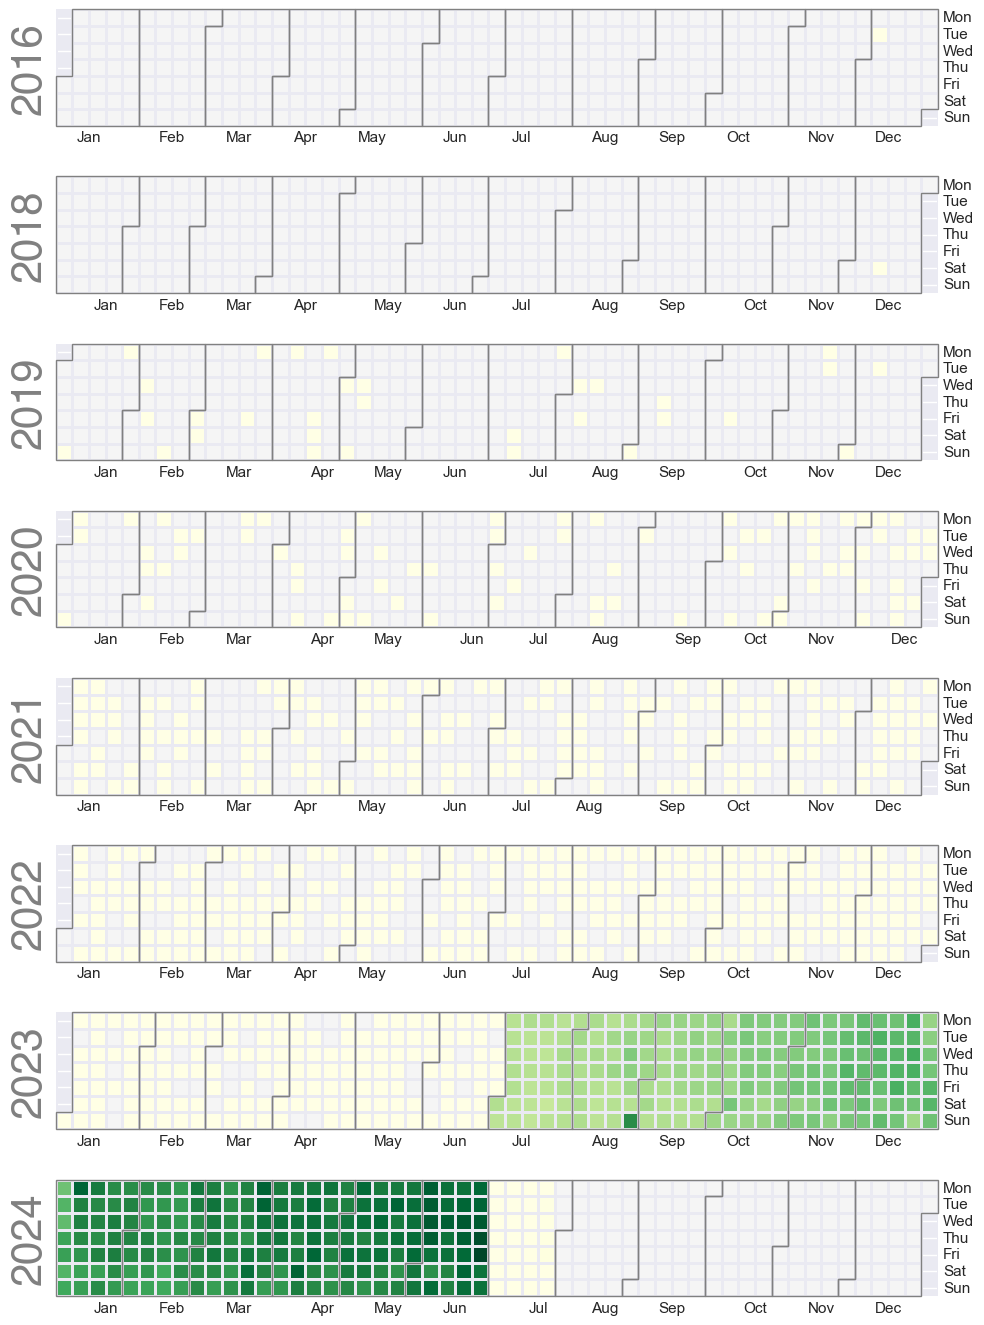

In [12]:
dates = pd.to_datetime(df["message_date"])

# Create a series with a date index and the message count for each date
messages_dates = dates.dt.date.value_counts().apply(lambda x: x/df.shape[0])
messages_dates.index = pd.to_datetime(messages_dates.index)

# visualize a data
calplot.calplot(messages_dates, cmap='YlGn', colorbar=False) 

**Findings:**
- As we can see, most messages were actually sent during the data-collection timeframe (July 2023 - July 2024).
- As expected, some messages were sent before the data collection timeframe. 
- The messages sent after the data collection period  will be dropped.

### 6. Verify Webpages

The column "urls" contains the urls of webpages referenced in a messages. To prepare them for further analysis down the line, we need to check if they adhere to valid url-formats.

To to so, we'll isolate invalid URLs and evaluate them manually.

In [13]:
# check, if urls are valid and save results in a list. If a message has no url, we consider it valid.
valid_url = df["webpage_url"].apply(lambda x: validators.url(x) if pd.notnull(x) else True) 

# As validator returns specific error messages, if a message is invalide, we need to replace them with False to use the filter in boolean indexing
invalid_url_filter = [False if elem == True else True for elem in valid_url]

df.loc[invalid_url_filter, ["webpage_url"]]

,webpage_url
69922,http://3.US-Militär/
171387,https://dna--awakening-org.translate.goog/are-...
199544,https://amg--news-com.translate.goog/seven-tru...
356868,https://off--guardian-org.translate.goog/2024/...
452060,https://rebelne.ws/4bhcfQL\
497550,https://amg--news-com.translate.goog/med-bed-l...
698101,https://amg--news-com.translate.goog/bombshell...
1610776,https://rebelne.ws/3F8sQs6\
1668014,https://rebelne.ws/3EPYYjQ\
1676697,https://www-renate--holzeisen-eu.cdn.ampprojec...


**Findings**

- Some of the urls contain backslashes, that should be removed.
- Some urls contain double dashes, which causes the url to be falsely flagged as invalid. These cases can be ignored.
- `http://3.US-Militär/	` is actually invalid and should be removed

### 7. Compare the Number of Messages per Chat

Last but not least, let us take a look at some descriptive statistics on how many messages were collected for each chat in our dataset. 

In [14]:
chats_message_counts = df.groupby("chat_name").size()
chats_message_counts.describe()

count     4969.000000
mean       394.404709
std       1585.022370
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max      10002.000000
dtype: float64

**Min & Distribution:** 
- As we can see, the distribution is highly skewed with the majority of chats containing 1 message, while a small number of chats make up a disproportionately large number of messages. This result is to be expected, as a quirk in the data collection process creates a lot of chats with only one message. 

**Max:** 
- The maximum is 100002. This, again, is to be expected, as the data collection process was limited to collect a maximum of 10.000 messages per chat. The two additional messages are presumably messages originating from this chat, that were found as forwarded messages in another chat. In this case, the data-collection software creates an entry for both chats. 

**Conclusion**: 
- As we need a certain amount of content and messages for the vectorisation of a chat, we should drop chats containing only few messages.

### 8. Check how many messages are part of a group

Telegram allows users to send several media files in one message — for example, a photo album. Each file is included as its own message in our dataset, which might interfere with our data analysis.

To decide how to handle them down the line, we'll:
- Check how many messages have a group-ID, which indicates that they are part of an album.

- Confirm that these messages are indeed media files sent as part of an album.

- Examine the average group size to estimate how many messages we'd lose if we choose to drop them.


**Check how many messages are part of the group:**

In [15]:
print(f"Raw count: {df["message_group_id"].notna().sum()}")
print(f"Percentage of messages: {(df["message_group_id"].notna().sum() / df.shape[0])*100}")

Raw count: 314224
Percentage of messages: 16.03349734691909


**Confirm that they are messages containing media:**

In [16]:
# get all grouped messages ant convert their ids to int
grouped_msgs = df[df["message_group_id"].notna()]
grouped_msgs.loc[:, "message_group_id"] = grouped_msgs["message_group_id"].astype(int)

# check their mediatype
print("Media Types of Messages with Group-ID:")
grouped_msgs["message_media_type"].value_counts(dropna=False)

Media Types of Messages with Group-ID:


message_media_type
MessageMediaPhoto               235431
MessageMediaDocumentVideo        66230
MessageMediaDocumentAudio         7384
MessageMediaDocumentDocument      4870
MessageMediaDocumentPhoto          280
MessageMediaDocumentOther           19
MessageMediaDocument                10
Name: count, dtype: int64

**Calculate the average group size:**

In [17]:
mean_group_size = np.mean(grouped_msgs.groupby("message_group_id").size())
mean_group_size

3.5352542105914515

**Calculate Estimated Loss if grouped messages are removed:**

As we won't work with images, videos and documents (the types of data usually sent in an album) we might only want to keep the message in the album that contains the messages text that was included in the album.

To get an estimate on how many messages we'd lose this way, we'll use the following formula: 

$\text{Estimated Messages Loss} = (\text{Average Group Size} - 1) \times \text{Number of Unique Groups}$


In [18]:
group_count = grouped_msgs["message_group_id"].nunique()
estimated_message_loss = (mean_group_size-1) * group_count

print(f"Mean group size: {round(mean_group_size,2)}")
print(f"Estimated messages lost (Raw Count): {int(estimated_message_loss)}")
print(f"Estimated messages lost (Percentage): {round(estimated_message_loss / df.shape[0] * 100,2)}")

Mean group size: 3.54
Estimated messages lost (Raw Count): 225340
Estimated messages lost (Percentage): 11.5


#### Findings:

- 16% of all messages are part of a group.

- All of them contain media.

- On average, groups contain between 3 and 4 messages.

- If we drop all grouped messages without a message text, we'll lose about 11.5% of all messages. 

## Data Cleaning

During the initial exploration we found the following tasks we need to adress before moving on to engineering the features for clustering:

- **Fix the faulty types.**

- **Replace NaN values in object-type columns with empty strings**

- **Drop `sender_display_name` and `post_author` columns**

- **Drop messages sent after the data collection period**

- **Clean urls (remove trailing backslashes and invalid links)**

- **Remove chats containing only few messages**

- **Drop grouped messages without text**

- **Delete duplicate rows**

- **(Optional) Aggregate datetime columns into broader time periods such as minutes, hours, days, or weeks.**


### 1. Clean Columns

First, we'll drop unnecessary columns and correct any faulty data types.

In [19]:
# drop columns
df.drop(labels=["sender_display_name","post_author"], axis=1, inplace=True)

# convert columns to datetime
df["collection_time"] = pd.to_datetime(df["collection_time"], errors='coerce')
df["message_date"] = pd.to_datetime(df["message_date"], errors='coerce')

# convert float columns to integer, while keeping NaN-values
df['fwd_from_chat_id'] = pd.to_numeric(df['fwd_from_chat_id'], errors='coerce').astype('Int64')
df['reply_to_message_id'] = pd.to_numeric(df['reply_to_message_id'], errors='coerce').astype('Int64')
df['reply_to_top_message_id'] = pd.to_numeric(df['reply_to_top_message_id'], errors='coerce').astype('Int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1959797 entries, 0 to 1959796
Data columns (total 30 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   chat_handle              object        
 1   chat_name                object        
 2   chat_type                object        
 3   collection_time          datetime64[ns]
 4   fwd_from_chat_handle     object        
 5   fwd_from_chat_id         Int64         
 6   fwd_from_user_name       object        
 7   is_fwd                   bool          
 8   is_group_elem            bool          
 9   is_reply                 bool          
 10  message_date             datetime64[ns]
 11  message_fwd_count        float64       
 12  message_group_id         float64       
 13  message_media_type       object        
 14  message_reactions        object        
 15  message_reactions_count  float64       
 16  message_text             object        
 17  message_view_count       fl

### 2. Replace NaN values in object-columns with empty strings. 

Next, we replace NaN values in object columns with empty strings to enable seamless text processing down the line. We'll reuse the object column list created earlier. 

In [20]:
# get the names of columns of type object
object_column_names = df.dtypes[df.dtypes == "object"].index.to_list()

# fill the NaN-values
df.loc[:, object_column_names] = df.loc[:, object_column_names].fillna('')

Now, we can check, if there are any elements of the type float left.

In [21]:
# create a dataframe containing the type of each cell
df_object_types =  df[object_column_names].map(type)

# print unique datatype for each column
for column in df_object_types.columns:
    print(f"Types in column \"{column}\"".upper())
    print(df_object_types[column].value_counts())
    print("")

TYPES IN COLUMN "CHAT_HANDLE"
chat_handle
<class 'str'>    1959797
Name: count, dtype: int64

TYPES IN COLUMN "CHAT_NAME"
chat_name
<class 'str'>    1959797
Name: count, dtype: int64

TYPES IN COLUMN "CHAT_TYPE"
chat_type
<class 'str'>    1959797
Name: count, dtype: int64

TYPES IN COLUMN "FWD_FROM_CHAT_HANDLE"
fwd_from_chat_handle
<class 'str'>    1959797
Name: count, dtype: int64

TYPES IN COLUMN "FWD_FROM_USER_NAME"
fwd_from_user_name
<class 'str'>    1959797
Name: count, dtype: int64

TYPES IN COLUMN "MESSAGE_MEDIA_TYPE"
message_media_type
<class 'str'>    1959797
Name: count, dtype: int64

TYPES IN COLUMN "MESSAGE_REACTIONS"
message_reactions
<class 'str'>    1959797
Name: count, dtype: int64

TYPES IN COLUMN "MESSAGE_TEXT"
message_text
<class 'str'>    1959797
Name: count, dtype: int64

TYPES IN COLUMN "SENDER_FIRST_NAME"
sender_first_name
<class 'str'>    1959797
Name: count, dtype: int64

TYPES IN COLUMN "SENDER_LAST_NAME"
sender_last_name
<class 'str'>    1959797
Name: count, 

### 3. Drop Messages sent after the data collection period

Now we drop all messages that were sent after June 2024.

In [22]:
end_data_collection = pd.Timestamp(year=2024, month=6, day=30)
filter_outliers_date = df["message_date"].dt.date > end_data_collection.date()
df = df[~filter_outliers_date]
print(f"Messages sent after end of data collection left: {(df["message_date"].dt.date > end_data_collection.date()).sum()}")

Messages sent after end of data collection left: 0


### 4. Clean URLs

Now we can clean up the urls by removing backslashes and invalid urls.



In [23]:
# remove trailing backspaces
df["webpage_url"] = df["webpage_url"].str.replace("\\\\$", '', regex=True)

# remove the urls manually found to be invalid
invalid_urls = ["http://3.US-Militär/"]
df.loc[df["webpage_url"].isin(invalid_urls) , "webpage_url"] = ''

### 5. Drop duplicates

As we don't plan on using information on connection based on replies, we can drop the duplicates. 

In [24]:
size_before = df.shape[0]
df = df.drop_duplicates()
print(f"Duplicates deleted: {size_before - df.shape[0]}")

Duplicates deleted: 2025


### 6. Remove Messages that are part of an album and contain no text

Next, we'll remove all messages that are part of an album and don't contain the album-messages text, as they inflate the message count of chats in our dataset, as this might interfer with the results of our analysis.

To make sure, that we don't lose any meaningful data, we'll check how many connections between chats (through forwarded messages) we lost by removing these messages.

In [25]:
# save messages per group counts and count of chats connected through forwarded messages for later comparison
group_message_counts = df["message_group_id"].value_counts()
message_per_group_counts_before = group_message_counts.value_counts()
forwards_pairs_before = df[["telegram_chat_id","fwd_from_chat_id"]].value_counts()

# drop all messages that are part of a group and contain no text.
mask_album_msg_without_text = (~pd.isna(df["message_group_id"])) & (df["message_text"]=='')
df_without_textless_grouped = df[~mask_album_msg_without_text]

# we should have mostly one message for each group. Let's check this to affirm, that everything worked as it should. 
group_message_counts = df_without_textless_grouped["message_group_id"].value_counts()
message_per_group_counts = group_message_counts.value_counts()

# create a dataframe to compare message counts per group before and after deleting messages without texts
message_counts_summary_df = pd.concat([message_per_group_counts_before, message_per_group_counts], axis=1)
message_counts_summary_df.columns = ["with non-text messages", "without non-text messages"]
print("Group Sizes:")
display(message_counts_summary_df.sort_index())

# calculate the amount of connections lost
forwards_pairs = df_without_textless_grouped[["telegram_chat_id","fwd_from_chat_id"]].value_counts()
print(f"Forward pairs lost: {abs(len(forwards_pairs)-len(forwards_pairs_before))}")


Group Sizes:


,with non-text messages,without non-text messages
count,,
1,678,80250
2,40546,407
3,17930,148
4,10167,74
5,5394,37
6,4506,20
7,2398,25
8,1675,11
9,1601,15


Forward pairs lost: 72


We still have some groups containing more than one message. Let's inspect them to rule out any issues with our dataset.
To do so, we'll have to actually look into the groups to see what causes grouped messages to have different texts. 

To find a suitable starting point, we'll isolate the chats with the most cases. 

In [26]:
albums_with_multiple_messages = group_message_counts[group_message_counts > 1].index
groups_with_multiple_messages = df_without_textless_grouped[df_without_textless_grouped["message_group_id"].isin(albums_with_multiple_messages)]
top_chats = groups_with_multiple_messages.groupby("chat_name").size().sort_values(ascending=False).head(5)

print(f"Chats with most grouped messages with different text: \n{top_chats}")

Chats with most grouped messages with different text: 
chat_name
Wehret den Anfängen #SieWarenNieWeg                                                                         848
Nahost-InfoKanal                                                                                            124
Heilende Musik, 432 Hz & Frequenzen 🌙, Meditation, Yoga, Entspannung, Reiki, Räuchern, Schamanismus usw.    123
Herzenslichter✨Garten                                                                                       113
Nichts Neues unter der Sonne - Wir mit Herz für Xavier Naidoo 🎧                                             106
dtype: int64


The manual inspection of chats pointed towards a peculiarity in the way Telegram handles messages containing multiple documents, audio files, images, or videos sent in the same message.

This is related to Telegram's "Captions" feature, which allows adding individual texts to elements of a grouped message.

- For images and videos, this is directly possible via the ["Captions" feature](https://web.archive.org/web/20240302001613/https://telegram.org/blog/captions-places), which allows each image/video to be assigned a unique caption from the photo editing panel.

- For documents and audio files, the option to assign individual captions for parts of grouped messages is not provided by Telegram. However, as GitHub user "Neurotoxin001" pointed out in [this thread](https://github.com/telegramdesktop/tdesktop/issues/8944), they can be added after sending a message by first sending the grouped files and editing each of them afterward.


##### Findings:

- For "classical" Albums, Telegram provides only one caption. As we won't work with the individual elements of an album, we'll keep only the message containing the caption.

- Telegram offers some workarounds to add individual captions to grouped messages containing files. Since each caption contains meaningful information on the chat's topic, we'll keep them. **To reflect their belonging to the same message, we may aggregate them later on.**

- We lost 72 connections by removing grouped messages without text.

### 7. Aggregate captions of grouped messages.

To make our dataset and its message count reflect the way telegram actually displays messages more closely, we'll aggregate captions of different media-files sent in the same grouped message. 

As the captions might not be the only columns with differing values across messages of a group, we have to be careful not to lose meaningful information. 

To make sure we don't, we'll:

1. Find columns that contain different values across messages belonging to a group (this might take a while)

2. Aggregate them into a single message, handling columns with different values properly.

In [27]:
# group our dataframe by messages group ids
grouped = df_without_textless_grouped.groupby("message_group_id")

# create a list of all column names with different values in the same group
differing_columns = set()
for group_id, group in grouped:
    differing_columns_group = [col for col in group.columns if group[col].nunique(dropna=False) > 1]
    differing_columns.update(differing_columns_group)

print("Columns with differing values across groups:")
print(differing_columns)

Columns with differing values across groups:
{'telegram_message_id', 'message_text', 'message_reactions', 'message_view_count', 'message_reactions_count', 'message_media_type', 'message_date', 'collection_time', 'message_fwd_count'}


In [28]:
# group our dataframe by messages group ids
grouped = df_without_textless_grouped.groupby("message_group_id")

# Define aggregation functions
def keep_min(series: pd.Series) -> Union[int,float,datetime]:
    return series.min()

def aggregate_text(texts: pd.Series, separator:str) -> str:
    return separator.join(texts)

def keep_available(series: pd.Series) -> Any:
    return series.dropna().iloc[0] if not series.dropna().empty else np.nan

def keep(series: pd.Series) -> Any:
    return series.iloc[0] #simply keep the first value, as we expect them to be identical across group rows

# intialise a dictionary with the aggregation methods we want to apply to the grouped message's columns as values and column names as keys.
aggregation_methods = dict()

# create a list of all column-names in our dataframe
all_cols = df_without_textless_grouped.columns.to_list()

# isolate all columns we want to keep unchanged and set their aggregation method to 'keep'
columns_to_keep = [col for col in all_cols if col not in differing_columns]
for col in columns_to_keep:
    aggregation_methods[col] = keep

# add methods for the columns we want to aggregate 
aggregation_methods["message_date"] = keep_min
aggregation_methods["telegram_message_id"] = keep_min
aggregation_methods["collection_time"] = keep_min
aggregation_methods["message_media_type"] = lambda x: aggregate_text(x, separator=',')
aggregation_methods["message_text"] = lambda x: aggregate_text(x, separator=' ')
aggregation_methods["message_reactions_count"] = keep_available
aggregation_methods["message_reactions"] = keep_available
aggregation_methods["message_view_count"] = 'mean'
aggregation_methods["message_fwd_count"] = 'mean'

# aggregate messages for each group using the methods defined above
aggregated_df = grouped.agg(aggregation_methods)

As aggregation can mess with the types of our dataframe-columns, we might need to correct them. 
Let's check for inconsistencies.

In [29]:
# Create a DataFrame to compare original and aggregated dtypes
original_types = df_without_textless_grouped.dtypes
aggregated_types = aggregated_df.dtypes

dtype_comparison = pd.DataFrame({
    "original": original_types,
    "aggregated": aggregated_types
})

# print columns with different types between our original df and the newly aggregated df
inconsistent_types = dtype_comparison[dtype_comparison["original"]!=dtype_comparison["aggregated"]]
print(f"Number of inconsistent types: {inconsistent_types.shape[0]}")

Number of inconsistent types: 0


In [30]:
# reset the index, as it is currently set to 'message_group_id'
aggregated_df = aggregated_df.reset_index(drop=True)

Now, we can compare the group-sizes again

In [31]:
group_message_counts = aggregated_df["message_group_id"].value_counts()
message_per_group_counts = group_message_counts.value_counts()

message_counts_summary_df_2 = pd.concat([message_counts_summary_df, message_per_group_counts], axis=1)
message_counts_summary_df_2.columns = ["with non-text messages", "without non-text messages", "after aggregation"]

print("Group Sizes:")
display(message_counts_summary_df_2.sort_index())    


Group Sizes:


,with non-text messages,without non-text messages,after aggregation
count,,,
1,678,80250,81009.0
2,40546,407,NaN
3,17930,148,NaN
4,10167,74,NaN
5,5394,37,NaN
6,4506,20,NaN
7,2398,25,NaN
8,1675,11,NaN
9,1601,15,NaN


Now, every group is represented by one message.

Finally, we can replace the grouped messages in our current dataframe with the ones we just aggregated.

In [32]:
# drop all messages that are part of a group
df_without_grouped_messages = df_without_textless_grouped[pd.isna(df_without_textless_grouped["message_group_id"])]

# replace them with the aggregated rows we created earlier
df_with_aggregated_groups = pd.concat([df_without_grouped_messages, aggregated_df])

Now that we got rid of grouped messages without a text and aggregated those with several captions into a single row, we can take another look at our dataframe.

We'll inspect:

1. If there are any groups with more than one message left.

2. How many messages we lost.

3. If the average message length increased (We expect this to be the case, as we deleted messages without text and aggregated others)

In [33]:
# check for groups with more than one message
group_sizes = df_with_aggregated_groups.groupby("message_group_id").size().value_counts()
print(f"Group Sizes in the dataframe:")
print(group_sizes)
print()

# calculate message loss
message_loss = abs(df.shape[0]-df_with_aggregated_groups.shape[0])
print(f"Message Loss: {message_loss}")
print()

# calculate average message length before and after aggregation:
avg_msg_len_before = np.mean(df["message_text"].apply(lambda x: len(x)))
avg_msg_len_after  = np.mean(df_with_aggregated_groups["message_text"].apply(lambda x: len(x)))
print(f"Average message length before aggregation: {avg_msg_len_before}")
print(f"Average message length after aggregation: {avg_msg_len_after}")


Group Sizes in the dataframe:
1    81009
Name: count, dtype: int64

Message Loss: 232870

Average message length before aggregation: 345.17492191465124
Average message length after aggregation: 391.8102182412483


As estimated, the changes increased the average message lenght, reduced each group to one messsage and deleted about 11% of our overall dataset.

### 8. Remove Chats containing only few messages

As we need a certain amount of content for the vectorisation and clustering of a chat, we'll drop those with fewer than 1000 available messages. 

Once we're done, we can check the message count statistics for improvements.

In [34]:
chats_message_counts = df_with_aggregated_groups.groupby("chat_name").size()
over_1000 = chats_message_counts[chats_message_counts > 1000]
over_1000_chat_names = list(over_1000.index)
df_over_1000 = df_with_aggregated_groups[df_with_aggregated_groups["chat_name"].isin(over_1000_chat_names)]

In [35]:
display(over_1000.describe())
print(f"Messages removed: {abs(df_with_aggregated_groups.shape[0] - df_over_1000.shape[0])}")
print(f"Chats removed: {abs(len(chats_message_counts)-len(over_1000))}")
print("")
print(f"Messages remaining: {df_over_1000.shape[0]}")
print(f"Chats remaining: {len(over_1000)}")

count      351.000000
mean      4505.692308
std       3009.233872
min       1005.000000
25%       1709.500000
50%       3600.000000
75%       7290.000000
max      10000.000000
dtype: float64

Messages removed: 142145
Chats removed: 3508

Messages remaining: 1581498
Chats remaining: 351


After removing 3508 chats containing 142145 messages, we're left with 351 chats with an average message count of 4506 and no fewer than 1005 messages.

## Exploratory Data Analysis

Next, we analyze and visualize the cleaned data to identify features and patterns that might be useful for clustering.



### 1. Compare Chat Types

As the type of chat dictates which datapoints are available, we first have to check the distribution of chat-types across our dataset.

Possible chat-types consist of:

- **Broadcast-Channels**: One-to-many communication. There are no replies from Members of this chat, but the API reports view- and forward-counts.

- **Megagroups**: Many-to-many communication. The API does not report detailled interaction-metrics, but there are replies.

To analyse their differences, we'll:

1. Check the distribution of chat-types in our dataset.


2. Look for differences in the available data for each chat type.

In [36]:
df_over_1000.groupby("telegram_chat_id")["chat_type"].unique().value_counts()

chat_type
[broadcast]    341
[megagroup]     10
Name: count, dtype: int64

As we can see, most of our channels are Broadcast-Channels.

**Next, let's see if we can find patterns in the available data for each chat.**

We will only keep messages that were forwarded from chats of the same type, as messages forwarded from other chat types might introduce information not natively available in the chat type we are analyzing. We'll use the complete dataset, to maximize the available datapoints. 

In [37]:
# create a dataframe and dictionary containing all the chat_ids in our initial dataset and the chat id as index
chats_type = df[["telegram_chat_id", "chat_type"]].drop_duplicates()
chats_type = chats_type.set_index("telegram_chat_id")
type_mapping = chats_type["chat_type"].to_dict()

# create a new column containing the type of the source chat
df.loc[:, "source_chat_type"] = df["fwd_from_chat_id"].map(type_mapping)

# replace NaN values in the newly created column to enable comparison with the "chat_type" column
df.loc[:, "source_chat_type"] = df["source_chat_type"].fillna('')

# get all messages that were forwarded from chats
is_fwd = df[(df["fwd_from_user_name"]=='')]
is_fwd = df[df["is_fwd"] == True]

# get all messages not forwarded
is_not_fwd = df[df["is_fwd"] == False]

# keep only messages that are forwarded and have the same source chat and chat type
is_fwd = is_fwd[is_fwd["chat_type"] == is_fwd["source_chat_type"]]

# add the cleaned forwarded messages and the non-forwarded messages back together
cleaned_types = pd.concat([is_fwd, is_not_fwd])

Now, we can compare missing data percentages per column for both types of data.

In [38]:
# Create seperate DataFrames for each "chat_type".
df_broadcast = cleaned_types[cleaned_types["chat_type"] == "broadcast"]
df_megagroup = cleaned_types[cleaned_types["chat_type"] == "megagroup"]

# Calculate percentage of missing values per column for chats of type "broadcast". Keep only columns with a missing value percentag > 0
missing_values_broadcast = df_broadcast.isna() | (df_broadcast == '')
missing_percentag_broadcast = missing_values_broadcast.sum().apply(lambda x: x/df_broadcast.shape[0])
missing_percentag_broadcast = missing_percentag_broadcast[missing_percentag_broadcast > 0]

# Calculate percentage of missing values per column for chats of type "megagroup". Keep only columns with a missing value percentag > 0
missing_values_megagroup= df_megagroup.isna() | (df_megagroup == '')
missing_percentag_megagroup = missing_values_megagroup.sum().apply(lambda x: x/df_megagroup.shape[0])
missing_percentag_megagroup =missing_percentag_megagroup[missing_percentag_megagroup > 0]

# Combine the two DataFrames into one 
combined_missing_percentages = pd.concat([missing_percentag_broadcast, missing_percentag_megagroup], axis=1)
combined_missing_percentages.columns = ['Missing Values Broadcast', 'Missing Values Megagroup']
combined_missing_percentages

,Missing Values Broadcast,Missing Values Megagroup
chat_handle,0.008326,0.539558
fwd_from_chat_handle,0.846497,0.999609
fwd_from_chat_id,0.844177,0.999441
fwd_from_user_name,1.000000,1.000000
message_fwd_count,0.113960,0.999721
message_group_id,0.839336,0.969259
message_media_type,0.084048,0.795685
message_reactions,0.377227,0.603862
message_reactions_count,0.377227,0.603862
message_text,0.227671,0.213789


##### Findings:

To check for meaningful differences between chat-types, we'll look at columns with extremly high missing percentages (over 95%) and higher availability in the other:

**message_fwd_count, message_view_count:** 
- Extremly high missing percentage for Broadcasts, as they are not provided by Telegram.

**sender_first_name, sender_last_name**: 
- Only available in Megagroups, as they allow differfent users to send messages. The user recorded for broadcasts has usually only the channels name as a username.

**fwd_from_chat_handle, fwd_from_chat_id, source_chat_type:** 
- Extremly high missing percentages for Megagroups. Indicates that there are few messages forwarded chats in Megagroups.

**reply_to_message_id:**
- Since Broadcasts do not support direct replies from recipients (only the broadcaster sends messages), the reply_to_message_id field is less relevant and often not used. However, it is possible for a broadcaster to forward messages with a reply status from other chats.

**webpage_author, webpage_description, webpage_title, webpage_url:** 
- These fields are more often missing in Megagroups, suggesting a lower number of messages linking to webpages.

**message_group_id:** 
- Low availability for Megagroups suggests that sending albums of media-files is less common. 

### 2. Inspect Message Type Ratios

Next, we'll analyse the distribution of different message types for each chat. 
We'll focus on the following message-type-ratios across all chats:

- **Forward Ratio**: The proportion of forwarded messages in each chat group.
- **Reply Ratio**: The proportion of replies in each chat group.
- **Webpage Ratio**: The proportion of messages containing a webpage URL in each chat group.
- **Image Ratio**: The proportion of messages containing at least one image in each chat group.
- **Video Ratio**: The proportion of messages containing at least one video in each chat group.
- **Document Ratio**: The proportion of messages containing at least one document in each chat group.

In [39]:
# avoid SettingWithCopyWarning
df_over_1000 = df_over_1000.copy()

# create flag-columns 
df_over_1000.loc[:, "is_webpage"] = df_over_1000["webpage_url"].apply(lambda x: False if x == '' else True)
df_over_1000.loc[:, "is_image"] = df_over_1000["message_media_type"].str.contains('MessageMediaPhoto|MessageMediaDocumentPhoto', regex=True)
df_over_1000.loc[:, "is_video"] = df_over_1000["message_media_type"].str.contains('MessageMediaDocumentVideo', regex=True)
df_over_1000.loc[:, "is_document"] = df_over_1000["message_media_type"].str.contains('MessageMediaDocumentDocument', regex=True)

# create a series containing chat sizes
chat_sizes = df_over_1000.groupby("telegram_chat_id").size()
# chat messages per chat
messages_per_chat = df_over_1000.groupby("telegram_chat_id")

# create a series containing the ratio of forwarded messages per chat.
fwd_msg_per_chat = messages_per_chat["is_fwd"].sum()
fwd_ratio_per_chat = fwd_msg_per_chat/chat_sizes

# create a series containing the ratio of media-messages per chat.
reply_msg_per_chat = messages_per_chat["is_reply"].sum()
reply_ratio_per_chat = reply_msg_per_chat/chat_sizes

# create a series containing the ratio of webpage messaages per chat.
webpage_msg_per_chat = messages_per_chat["is_webpage"].sum()
webpage_ratio_per_chat = webpage_msg_per_chat/chat_sizes

# create a series containing the ratio of image messages per chat.
image_msg_per_chat = messages_per_chat["is_image"].sum()
image_ratio_per_chat = image_msg_per_chat/chat_sizes

# create a series containing the ratio of video messages per chat.
video_msg_per_chat = messages_per_chat["is_video"].sum()
video_ratio_per_chat = video_msg_per_chat/chat_sizes

# create a series containing the ratio of video messages per chat.
doc_msg_per_chat = messages_per_chat["is_document"].sum()
doc_ratio_per_chat = doc_msg_per_chat/chat_sizes

Now, we can compare the distribution of different message types across all chats. 


We'll use a violin plot, as it combines both information on the distribution’s density and spread. 

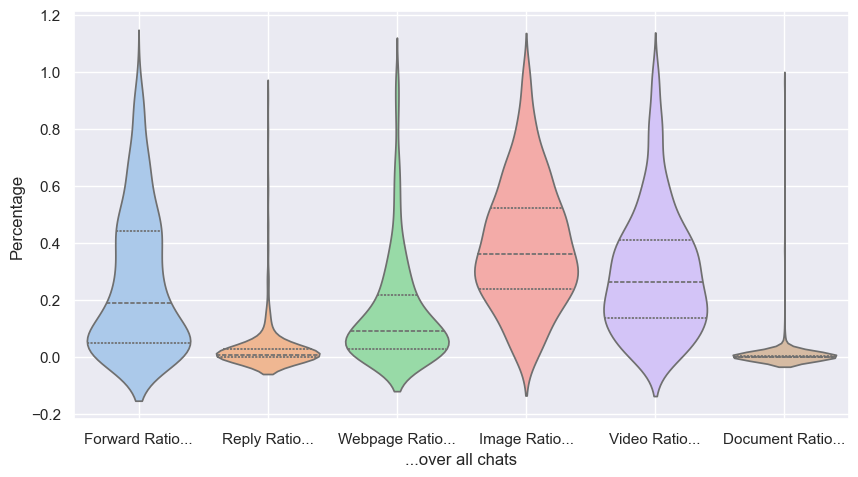

In [40]:
data = [fwd_ratio_per_chat, reply_ratio_per_chat, webpage_ratio_per_chat, image_ratio_per_chat, video_ratio_per_chat, doc_ratio_per_chat]
labels = ['Forward Ratio...', 'Reply Ratio...', 'Webpage Ratio...', 'Image Ratio...', 'Video Ratio...', 'Document Ratio...']
dfs = []

# Create a DataFrame for visualisation
for dataset, label in zip(data, labels):
    
    df_ratio = pd.DataFrame({
        'Ratio': dataset,
        'Metric': label
    })
    
    dfs.append(df_ratio)
ratios = pd.concat(dfs, ignore_index=True)

# Create the violin plots
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(x='Metric', y='Ratio', data=ratios, ax=ax, palette='pastel', inner="quart", hue="Metric", legend=False)
ax.grid(True)
fig.subplots_adjust(bottom=0.2)
ax.set_xlabel('...over all chats')
ax.set_ylabel('Percentage')
plt.show()

**Forward Ratio**:
- The distribution is broad with a significant number of chats having a forward ratio between 5% and 20%.
- There are a few chats with very high forward ratios (close to 1), indicating that some chats have a high proportion of forwarded messages. These could have the purpose of being "Aggregators".
- The distributions are spread out, which makes forward ration a distinctive feature.

**Reply Ratio:**
- The distribution is very narrow and close to zero for most chats.
- This indicates that replies are relatively rare in the chats of our dataset.
- As most of our chats are Broadcast Channels and don't allow replies this is to be expected.

**Webpage Ratio:**
- The distribution shows a moderate density around a ratio of 0 to 0.2.
- This suggests that a small but consistent proportion of messages contain webpage URLs.

**Image Ratio:**
- The distribution is wider and peaks around 0.3 to 0.5, indicating that many chat have a substantial proportion of image messages.
- There are also chats with very high image ratios, showing that some chats predominantly share images.

**Video Ratio:**
- The distribution is somewhat similar to the image ratio but slightly lower, peaking around 0.2 to 0.4.
- This indicates that video messages are common but less frequent than image messages.

**Document Ratio:**
- The distribution is very narrow and close to zero for most chat chats.
- This indicates that document messages are quite rare across the chats.


### 3. Inspect available webpage information
Telegram can provide additional information about webpages, such as the author, title, and a brief summary of their content. To determine the usefulness of this information, we need to assess how commonly it appears in our dataset.

In [41]:
webpage_messages = df_over_1000[df_over_1000["is_webpage"] == True]
nr_webpage_messages = webpage_messages.shape[0]

nr_has_webpage_author = webpage_messages[webpage_messages["webpage_author"]!=''].shape[0]
nr_has_webpage_description = webpage_messages[webpage_messages["webpage_description"]!=''].shape[0]
nr_has_webpage_title = webpage_messages[webpage_messages["webpage_title"]!=''].shape[0]

print(f"Percentage of webpage messages with author: {round(nr_has_webpage_author/nr_webpage_messages*100, 2)}")
print(f"Percentage of webpage messages with description: {round(nr_has_webpage_description/nr_webpage_messages*100, 2)}")
print(f"Percentage of webpage messages with title: {round(nr_has_webpage_title/nr_webpage_messages*100, 2)}")

Percentage of webpage messages with author: 35.96
Percentage of webpage messages with description: 91.24
Percentage of webpage messages with title: 96.0


##### Findings:
- As we can see, most messages in our dataset that contain a reference to webpage also provide a description and a title. 

- Authors are less frequently provided.


### 4. Connections between chats

We have established, that a meaningful amount of messages in our chats are forwarded from other chats. Let's take a closer look at these connections. A connection is defined as a pair of a source chat (the chat a message was forwaded from) and a target chat (the chat we found the message in).

To inspect these connections, we'll calculate:

1) The frequency distribution of source chats in our dataset.

2) How often source chats appear across different chats.

2) The amount of unique connections per chat.

3) The percentage of unique connections out of all connections per chat.


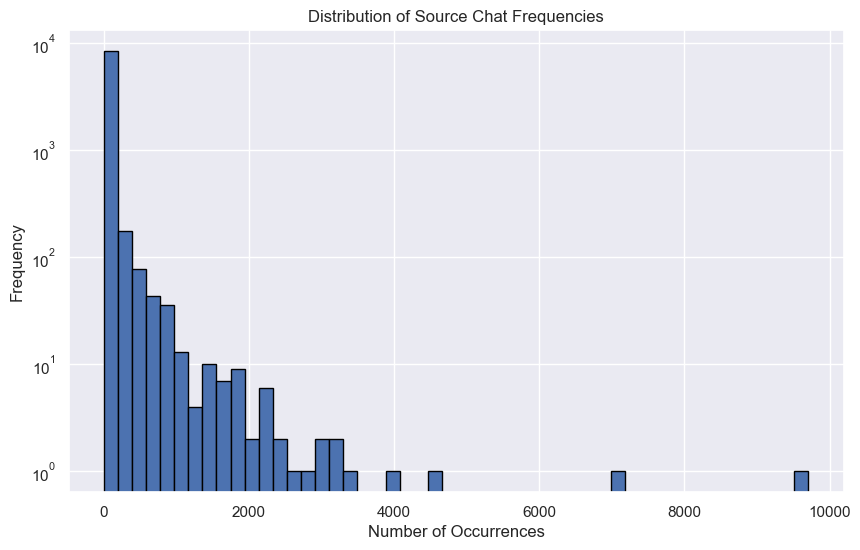

In [42]:
# get all messages forwarded from chats (and not from users)
forwarded_messages = df_over_1000[(df_over_1000["is_fwd"])&((df_over_1000["fwd_from_user_name"]==''))]

# get all connections between chats & drop messages forwarded from private chat (which lead to fwd_from_chat_id being unknown)
connections = forwarded_messages[["telegram_chat_id","fwd_from_chat_id"]]
connections = connections[~pd.isna(connections["fwd_from_chat_id"])]

# calculate the number of times source chats occurs in our dataset
frequency_of_source_chats = connections[["fwd_from_chat_id"]].value_counts()

# display the distribution of connection-frequencies
plt.figure(figsize=(10, 6))
frequency_of_source_chats.plot(kind='hist', bins=50, edgecolor='black')
plt.title('Distribution of Source Chat Frequencies')
plt.xlabel('Number of Occurrences')
plt.yscale("log")
plt.ylabel('Frequency')
plt.show()


In [43]:
# group forwarded messages by chat
grouped = connections.groupby("telegram_chat_id")

# get unique source chats for each chat
source_chats_per_chat = grouped["fwd_from_chat_id"].unique()

# count occurances of source chats across chats in our dataset
source_occurances_count = {}
for group in source_chats_per_chat:
    for source in group:
        if source in source_occurances_count:
            source_occurances_count[source] += 1
        else:
            source_occurances_count[source] = 1

print("Occurances of source chats across different chats:")
pd.Series(source_occurances_count).describe()

Occurances of source chats across different chats:


count    8790.00000
mean        4.96041
std        10.22141
min         1.00000
25%         1.00000
50%         2.00000
75%         4.00000
max       127.00000
dtype: float64

In [44]:
# get all unique connections between chats
unique_connections = connections.drop_duplicates()

# group connections by chat ID
forwarded_messages_per_chat = forwarded_messages.groupby("telegram_chat_id").size()
unique_connections_per_chat = unique_connections.groupby("telegram_chat_id").size()

# create a dataFrame to align the indices of the metrics calculated above
metrics_df = pd.DataFrame({
    'forwarded_messages_count': forwarded_messages_per_chat,
    'unique_connections_count': unique_connections_per_chat
})

#unique_percentages_per chat = metrics_df
metrics_df["unique_connection_percentage"] = metrics_df["unique_connections_count"]/metrics_df["forwarded_messages_count"]

print("Unique connection count per chat:")
display(metrics_df["unique_connections_count"].describe())
print()

print("Unique connection percentages per chat:")
display(metrics_df["unique_connection_percentage"].describe())

Unique connection count per chat:


count    338.000000
mean     129.000000
std      161.549177
min        1.000000
25%       19.000000
50%       66.000000
75%      184.000000
max      805.000000
Name: unique_connections_count, dtype: float64


Unique connection percentages per chat:


count    338.000000
mean       0.195394
std        0.187677
min        0.000974
25%        0.078378
50%        0.133901
75%        0.252806
max        1.000000
Name: unique_connection_percentage, dtype: float64

#### Findings


**Source Chat frequencies**
- Ignoring some outlier, wich ocurr between 4000 and 9000 times, a majority of source chats in our dataset are relatively unique and seldome occur more than 500 times. 

**Source Chat distribution across chats**
- The majority of source chats have limited spread, appearing in a few chats only. However, the presence of source chats that appear in many different chats suggests there are a few highly influential or central chats in the network.

**Unique connections per chat**
- On average, chats have few unique connections, with 75% of the chats having a unique connection percentage of 25.28% or less. This points towards a significant portion of forwarded message originating from repeated sources.

- Some outliers get their forwarded messages only from a single chat or exclusively from unique connections. 


### 5. Check languages of messages,  webpages and chats

Now, we'll inspect the language of the chats and messages in our dataset. 
To do so, we'll use a fasttext-model for language identification, which can be found [here](https://fasttext.cc/docs/en/language-identification.html).

As the model was trained on UTF-8 data, it expects UTF-8 as input. This sould be the case, as pandas `read_csv`-function imports text in UTF-8 by default.

We'll approach the task differntly for each text category:

1. For messages, we'll simply check the messages text. 

2. For webpages, we'll check the description (if provided)

3. For chats, well aggregate their messages and webpage description to inspect the most prominent languages per chat.

4. If we find multilingual chats, we'll inspect their language composition.

#### Download model:

First, we need to download the fasttext-model.

In [45]:
# download the fasttext model

fasttext_path = os.path.join(os.getcwd(), '../data/models/lid.176.bin')

if not os.path.isfile(fasttext_path):
    !wget -O {fasttext_path} https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
else:
    print("Fasttext-Model already downloaded")

Fasttext-Model already downloaded


#### Identify languages:

Now we can use the model to identify the languages of our messages and webpage descriptions. This might take some time. 

In [46]:
# load the model
fasttext_model = fasttext.load_model(fasttext_path)

def identify_language(text):
    lang_detected = fasttext_model.predict(text)
    return lang_detected[0][0]

# clean the webpage text, as the model expect text without newlines
df_over_1000.loc[:,"webpage_description"] = df_over_1000["webpage_description"].str.replace("\n"," ")

# detect message-  and webpage-languages. If the column contains empty text, the language is set to nan
df_over_1000.loc[:,"message_text_lang"] = df_over_1000["message_text"].apply(lambda x: identify_language(x) if not x == '' else np.nan)
df_over_1000.loc[:,"webpage_description_lang"] = df_over_1000["webpage_description"].apply(lambda x: identify_language(x) if not x == '' else np.nan)

# clean the output
df_over_1000.loc[:,"message_text_lang"] = df_over_1000["message_text_lang"].str.replace("__label__","")
df_over_1000.loc[:,"webpage_description_lang"] = df_over_1000["webpage_description_lang"].str.replace("__label__","")

# print the new columns
pd.concat([df_over_1000["message_text_lang"], df_over_1000["webpage_description_lang"]], axis=1).head()

,message_text_lang,webpage_description_lang
1259,en,NaN
1260,en,NaN
1261,en,en
1262,en,en
1263,en,NaN


As the fasttext-model returns ISO-639 language code, which we'll resolve for easier interpretation. 

The dataset used for this purpose can be found [here](https://github.com/datasets/language-codes/blob/master/data/language-codes-full.csv).

In [47]:
iso_path = os.path.join(os.getcwd(), "../data/auxiliary/language-codes-full.csv")
iso639_mapping = pd.read_csv(iso_path)

# create a dictionary of alpha2 encodings and delete the key 'nan'
alpha2 = iso639_mapping.set_index("alpha2")["English"].to_dict()
alpha2 = {k: v for k, v in alpha2.items() if not pd.isna(k)}

df_over_1000.loc[:,"message_text_lang"] = df_over_1000["message_text_lang"].map(alpha2, na_action='ignore')
df_over_1000.loc[:,"webpage_description_lang"] = df_over_1000["webpage_description_lang"].map(alpha2, na_action='ignore')
pd.concat([df_over_1000["message_text_lang"], df_over_1000["webpage_description_lang"]], axis=1).head(20)

,message_text_lang,webpage_description_lang
1259,English,NaN
1260,English,NaN
1261,English,English
1262,English,English
1263,English,NaN
1264,NaN,NaN
1265,English,English
1266,English,English
1267,English,English
1268,English,NaN


#### Inspect Language Distributions of Messages and Webpages:

Let's take a look at the language distributions of the messages and webpage description in our dataset.

In [48]:
# calculate language distributions for messages
language_distribution = df_over_1000["message_text_lang"].value_counts()

# group all languages with fewer than 2500 messages into "other"
others = language_distribution[language_distribution < 2500].sum()
language_distribution = language_distribution[language_distribution > 2500]
language_distribution["Other"] = others

# calculate language distributions for webpage descriptions
language_distribution_wp = df_over_1000["webpage_description_lang"].value_counts()

# group all languages with fewer than 2500 messages into "other"
others_wp = language_distribution_wp[language_distribution_wp < 2500].sum()
language_distribution_wp = language_distribution_wp[language_distribution_wp > 2500]
language_distribution_wp["Other"] = others_wp

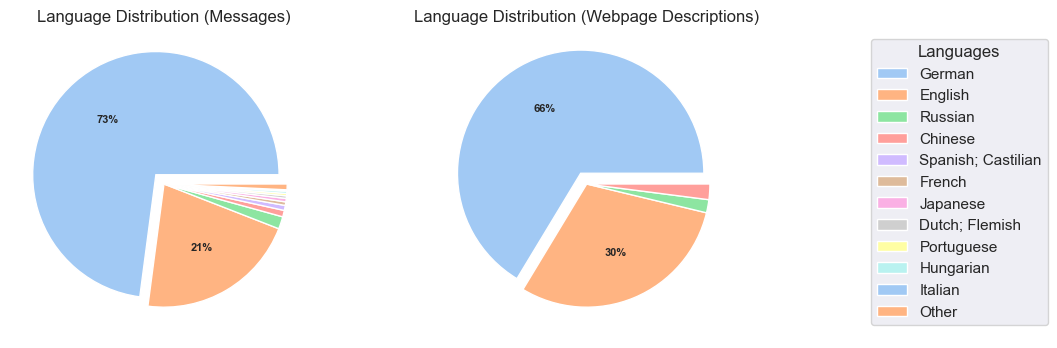

In [49]:
# visualize the distributions

# define color scheme
colors = sns.color_palette('pastel')

# create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), subplot_kw=dict(aspect="equal"))

def hide_small_pct(pct):
    return ('%.0f%%' % pct) if pct > 5 else ''

# create message pie chart
explode_messages = [0.1 if i == 'German' else 0 for i in language_distribution.index] # highlight the german wedge
wedges, texts, autotexts = ax1.pie(language_distribution, colors=colors,
                                  explode=explode_messages, autopct=hide_small_pct)
ax1.set_title("Language Distribution (Messages)")

# create webpage pie chart
explode_wp = [0.1 if i == 'German' else 0 for i in language_distribution_wp.index] # higlight the german wedge
wedges_wp, texts_wp, autotexts_wp = ax2.pie(language_distribution_wp, colors=colors,
                                  explode=explode_wp, autopct=hide_small_pct)
ax2.set_title("Language Distribution (Webpage Descriptions)")

# Combine wedges and labels from both pie charts for the legend
all_wedges = wedges + wedges_wp
all_labels = list(language_distribution.index) + list(language_distribution_wp.index)
unique_labels = list(dict.fromkeys(all_labels))
filtered_wedges = [wedges[all_labels.index(label)] for label in unique_labels]

# Create legend
fig.legend(filtered_wedges, unique_labels,
           title="Languages",
           loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1))

# display plot
plt.setp(autotexts, size=8, weight="bold")
plt.setp(autotexts_wp, size=8, weight="bold")
plt.show()

#### Inspect Languages of Chats

Now we can inspect the majority language of our chats. 

In [50]:
# group messages and webpage descriptions by chat
grouped = df_over_1000.groupby("telegram_chat_id")
message_lang_per_chat = grouped["message_text_lang"].value_counts()
webpage_lang_per_chat = grouped["webpage_description_lang"].value_counts()

In [51]:
# convert the multi-indexed series into a dataframe
#       index:      chat id
#       columns:    language names
#       cells:      number of messages or webpages in a chat in a language

message_lang_per_chat_df = message_lang_per_chat.unstack(fill_value=0)
webpage_lang_per_chat_df = webpage_lang_per_chat.unstack(fill_value=0)

# sum the language counts of messages and webpages for each chat
lang_per_chat = message_lang_per_chat_df.add(webpage_lang_per_chat_df, fill_value=0)

# get the language with most frequent messages/webpages per chat
most_frequent_lang = lang_per_chat.idxmax(axis=1)

# calculate the distribution of most frequent languages in our chats
most_frequent_lang_distr = most_frequent_lang.value_counts()

# group all languages with fewer than 5 chats into "other"
others_chats = most_frequent_lang_distr[most_frequent_lang_distr < 5].sum()
language_distribution_chats = most_frequent_lang_distr[most_frequent_lang_distr > 5]
language_distribution_chats["Other"] = others_chats

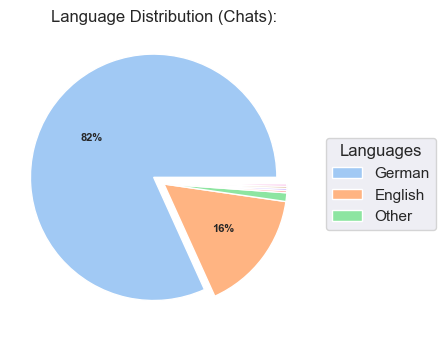

In [52]:
# visualize the distributions
# define color scheme
colors = sns.color_palette('pastel')

# create figure
fig, ax = plt.subplots(figsize=(10, 4))

# create chat distribution pie chart
explode_messages = [0.1 if i == 'German' else 0 for i in most_frequent_lang_distr.index] # highlight the german wedge
wedges, texts, autotexts = ax.pie(most_frequent_lang_distr.values, colors=colors,
                                  explode=explode_messages, autopct=hide_small_pct)
ax.set_title("Language Distribution (Chats):" )

ax.legend(wedges, language_distribution_chats.index,
          title="Languages",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")
plt.show()

#### Check for multilingual chats

Finally, we can check how many chats contain a substancial amount of messages in different languages. 

For our purpose, every chat with more than 25% of messages and webpage description in another language than the most frequent one is considered "multilingual". 

In [53]:
threshold=0.75

# calculate messages + webpage description sums for each chat
text_count_per_chat = lang_per_chat.sum(axis=1)

# calculate languge percentages for each chat
language_per_chat_pct = lang_per_chat.div(text_count_per_chat, axis=0)

# get chats, where the most frequent language has a percentage < 75%
multilingual_chats = language_per_chat_pct[language_per_chat_pct.max(axis=1) < threshold]

# get descriptive statistics about the language variety in multilingual chats by inspecting the pecentage values of the most common language
print("Percentage made up of the most frequent languages per chat:")
multilingual_chats.max(axis=1).describe()

Percentage made up of the most frequent languages per chat:


count    36.000000
mean      0.628928
std       0.100035
min       0.368985
25%       0.578886
50%       0.661642
75%       0.709481
max       0.747300
dtype: float64

#### Chat Language Compositions

We have confirmed, that there are multilingual chats. Now, let's look at their language composition.

To isolate the composition of each chat, we'll:

1. **Set Threshold:** Setting a threshold to 1%, meaning, we'll consider each language that makes up more of 1% of a chat a part of its language composition.

2. **Create a Boolean Index:** Identify languages that make up a percentage of a chat's content above the specified threshold. This Boolean index will indicate whether each language in a chat meets this condition.

3. **Calculate the Dot Product of the Boolean Index and Column Names:** Performing a dot product between this Boolean index and the column names will generate a string of column names (representing languages) that pass the threshold, as `True` is treated as 1 and `False`is treated as 0. Accordingly, only the column names corresponding to True are kept. 
We'll concatenated them with semicolons, as some language names contain commata.


In [54]:
treshold = 0.01
multilingual_chats_composition = (multilingual_chats>treshold).dot(multilingual_chats.columns+';').str.rstrip(';')

print("Top 10 Language Combinations:")
multilingual_chats_composition.value_counts().head(10)

Top 10 Language Combinations:


English;German                                                              11
English;French;German;Russian                                                3
Chinese;English;German                                                       2
Dutch; Flemish;English;French;German;Japanese;Russian                        2
English;German;Spanish; Castilian                                            2
Chinese;English;French;German;Italian                                        1
Chinese;English;French;German;Japanese;Russian                               1
Chinese;English;French;German;Japanese;Russian;Spanish; Castilian            1
Chinese;English;German;Japanese;Russian;Spanish; Castilian;Turkish           1
Chinese;English;Finnish;French;German;Italian;Japanese;Malayalam;Russian     1
Name: count, dtype: int64

#### Findings:

**Message- and Webpage-Languages:**
- The majority of our chats, messages and webpage descriptions are German. 

- However, there's a significant amount of English texts in our datasets.

- A small, but notable amout of Content is Russian and Chinese.

**Chat Languages:**

- The majority of chats contain predominently german content.

- A small subgroup of chats contains predominently english content.

**Multilingual Chats:**

- Even in chats where the majority language makes up less than 75% of all content, the majority usually still accounts for more than 50% of the chat.

- Such multilingual chats make up a small part of the chats in our dataset.

- If we consider each language that makes up more than 1% of a chat's content, the most prominent language combination is German and English.


### 6. Check for duplicated messages between chats

Lastly, we'll check how many message texts are occurring in more than one chat. 

This might happen, if a message was forwarded from one chat to the other. In this case it is saved twice - once for the source chat and once for the target chat. 

We'll approach the task by:

1. Calculating the number of duplicated texts.

2. Calculating the number of duplicated texts between chats, as some chats might send the same text multiple times as part of their "branding".

3. Analysing messages with duplicated texts and occurances in more than one chat.



#### Calculate the number of duplicated texts

In [176]:
# get all duplicates while keeping all occurances of a message with duplicated message text
duplicates_msg_filter = df_over_1000["message_text"].duplicated(keep=False)
duplicates_msg_text = df_over_1000[duplicates_msg_filter]

# drop messages with an empty message text to avoid them being counted as duplicates of each other
duplicates_msg_text = duplicates_msg_text[duplicates_msg_text["message_text"]!='']

print(f" Number of messages with duplicated texts: {duplicates_msg_text.shape[0]}")

 Number of messages with duplicated texts: 425693


In [191]:
# Confirm, that there are only duplicates left in our dataframe
grouped = duplicates_msg_text.groupby("message_text")
occurance_counts = grouped.size()
print(f"Duplicated message text with fewest occurances in our dataset: {min(occurance_counts)}")
print(f"Only duplicates left: {min(occurance_counts) > 1}")

Duplicated message text with fewest occurances in our dataset: 2
Only duplicates left: True


#### Calculating the number of duplicated texts between chats

In [230]:
# count unique telegram_chat_ids in each group
unique_chat_id_counts = grouped['telegram_chat_id'].nunique()

# isolate the indices of message texts that occur in more than one chat
duplicated_message_texts = unique_chat_id_counts[unique_chat_id_counts > 1].index

# isolate messages with duplicated texts across different chats
duplicates_msg_text_btw_chats = df[df['message_text'].isin(duplicated_message_texts)]

# confirm that there are only messages with multiple occurances in more than one chat left
test_groups = duplicates_msg_text_btw_chats.groupby("message_text")
chat_count = test_groups["telegram_chat_id"].nunique()
print(f"Chat count of duplicated message with fewest occurances in different chats: {min(chat_count)}")
print(f"Only duplicates left: {min(chat_count) > 1}")

Chat count of duplicated message with fewest occurances in different chats: 2
Only duplicates left: True


In [240]:
print(f" Number of messages with duplicated texts in different chats: {duplicates_msg_text_btw_chats.shape[0]}")

# display the first 40 duplicate messages
display(duplicates_msg_text_btw_chats[["chat_handle", "message_text", "fwd_from_chat_handle"]].sort_values(by = "message_text").head(40))

 Number of messages with duplicated texts in different chats: 347525


,chat_handle,message_text,fwd_from_chat_handle
686322,MAHUMO21,!,
1239759,TimeTraveller17,!,
1830624,exspiner,!,selbstdenken
678719,TimeTraveller17,!,
1580296,DoQusMusik,!,
1830625,exspiner,!,selbstdenken
1806786,videodump1,!,
599224,DanielPrinzOffiziell,! **Ganze Sendung ! 👆🏼👆🏼👆🏼** **⚠️ TATORT IMPFE...,Impfschaede
603328,FrMaWa,! **Ganze Sendung ! 👆🏼👆🏼👆🏼** **⚠️ TATORT IMPFE...,Impfschaede
607182,vereinigteWahrheitsbewegung,! **Ganze Sendung ! 👆🏼👆🏼👆🏼** **⚠️ TATORT IMPFE...,Impfschaede


## Export cleanded data

With the data cleaned and initial analyses complete, we will now export the dataset to a CSV file. This file will be used for feature engineering and the actual experiment.

In [54]:
import json

# save cleaned dataframe as csv
file_path = os.path.join(os.getcwd(), '../data/csv/cleaned_data.csv')
df_over_1000.to_csv(file_path, index=False)

# Save the data types of our dataframe as a JSON file
dtypes_dict = df_over_1000.dtypes.apply(lambda x: x.name).to_dict()
dtypes_path = os.path.join(os.getcwd(), '../data/auxiliary/cleaned_data_dtypes.json')
with open(dtypes_path, 'w') as f:
    json.dump(dtypes_dict, f)